# Inverse design optimization of a compact grating coupler.

The ability to couple light in and out of photonic integrated circuits (PICs) is crucial for developing wafer-scale systems and tests. This need makes designing efficient and compact grating couplers an important task in the PIC development cycle. In this notebook, we will demonstrate how to use [Tidy3D's adjoint plugin](../notebooks/AdjointPlugin_1_Intro.html) to perform the inverse design of a compact 3D grating coupler. We will show how to improve design fabricability by enhancing permittivity binarization and controlling the device's minimum feature size.

Note: This notebook contains several large simulations. Running the entire notebook in optimization mode will cost about 30 FlexCredits and could take several hours.

We start by importing our typical python packages, `jax`, `tidy3d` and its `adjoint` plugin.

In [29]:
# Standard python imports.
from typing import List
import numpy as np
import scipy as scp
import matplotlib.pylab as plt
import os
import json

# Import jax to be able to use automatic differentiation.
import jax.numpy as jnp
import jax.scipy as jsp
from jax import value_and_grad

# Import regular tidy3d.
import tidy3d as td
import tidy3d.web as web

# Import the components we need from the adjoint plugin.
from tidy3d.plugins.adjoint import JaxSimulation, JaxBox, JaxCustomMedium, JaxStructure
from tidy3d.plugins.adjoint import (
    JaxSimulationData,
    JaxDataArray,
    JaxPermittivityDataset,
)
from tidy3d.plugins.adjoint.web import run


## Grating coupler inverse desing configuration.

The grating coupler inverse design begins with a rectangular design region connected to a $Si$ waveguide. Throughout the optimization process, this initial structure evolves to convert a vertically incident Gaussian-like mode from an optical fiber into a guided mode and then funnel it into the $Si$ waveguide.

We are considering a full-etched grating structure, so a $SiO_{2}$ BOX layer is included. To recover light scattered into the substrate and reduce backreflection, we added a metallic mirror and adjusted the fiber tilt angle to $10^{\circ}$ [[1](https://doi.org/10.1364/OE.23.022628), [2](https://doi.org/10.3390/mi11070666)].

In the following block of code, you can find the parameters that can be modified to configure the grating coupler structure, optimization, and simulation setup. Special care should be devoted to the `opt_steps` variable bellow.

In [30]:
# Geometric parameters.
w_thick = 0.22  # Waveguide thickness (um).
w_width = 0.5  # Waveguide width (um).
w_length = 1.0  # Waveguide length (um).
box_thick = 1.6  # SiO2 BOX thickness (um).
spot_size = 2.5  # Spot size of the input Gaussian field regarding a lensed fiber (um).
fiber_tilt = 10.0  # Fiber tilt angle (degrees).
src_offset = 0.05  # Distance between the source focus and device (um).

# Material.
nSi = 3.48  # Silicon refractive index.
nSiO2 = 1.44  # Silica refractive index.

# Design region parameters.
gc_width = 4.0  # Grating coupler width (um).
gc_length = 4.0  # Grating coupler length (um).
dr_grid_size = 0.015  # Grid size in within the design region (um).

# Inverse design set up parameters.
it_per_step = 5  # Number of iterations per optimization step.
#################################################################
# Number of optimization steps.
opt_steps = 1  
# Note: the previous optimization was done using opt_steps = 30.
# The total number of iterations = opt_steps x it_per_step.
#################################################################
feature_size = 0.06  # Minimum feature size (um).
eta = 0.50  # Threshold value for the projection filter.
init_beta = 1.0  # Sharpness parameter for the projection filter.
del_beta = 1.0  # Increments of beta at each optimization step.
fom_name = "fom_field"  # Name of the monitor used to compute the objective function.

# Optimization output file name.
output_file = "./misc/opt_gc.json"

# Simulation wavelength.
wl = 1.55  # Central simulation wavelength (um).
bw = 0.100  # Simulation bandwidth (um).
n_wl = 101  # Number of wavelength points within the bandwidth.

By default, this notebook is in view mode. This means that if `output_file` is a valid file, the results of a previous optimization are loaded and only the final structure is simulated. Otherwise, a new optimization is run. The JSON file used in this notebook can be downloaded from our documentation [repo](https://github.com/flexcompute-readthedocs/tidy3d-docs/tree/readthedocs/docs/source/notebooks/misc).

In [31]:
view_mode = True
prev_data = []
if os.path.isfile(output_file):
    with open(output_file, "r", encoding="utf-8") as json_file:
        prev_data = json.load(json_file)[0]
else:
    view_mode = False

print(f"View mode = {view_mode}")


View mode = False


## Inverse design optimization set up.

We will calculate the values of some parameters used throughout the inverse design set up.

In [32]:
# Minimum and maximum values for the permittivities.
eps_max = nSi**2
eps_min = 1.0

# Material definitions.
mat_si = td.Medium(permittivity=eps_max)  # Waveguide material.
mat_sio2 = td.Medium(permittivity=nSiO2**2)  # Substrate material.

# Wavelengths and frequencies.
wl_max = wl + bw / 2
wl_min = wl - bw / 2
wl_range = np.linspace(wl_min, wl_max, n_wl)
freq = td.C_0 / wl
freqs = td.C_0 / wl_range
freqw = 0.5 * (freqs[0] - freqs[-1])
run_time = 5e-12

# Computational domain size.
size_x = 0.51 * wl + w_length + gc_length
size_y = gc_width + 1.02 * wl
size_z = w_thick + box_thick + 0.51 * wl
center_z = size_z / 2 - 0.51 * wl - w_thick / 2

# Inverse design variables.
src_pos_z = w_thick / 2 + src_offset
mon_pos_x = -size_x / 2 + 0.25 * wl
mon_w = int(3 * w_width / dr_grid_size) * dr_grid_size
mon_h = int(5 * w_thick / dr_grid_size) * dr_grid_size
nx = int(gc_length / dr_grid_size)
ny = int(gc_width / dr_grid_size / 2.0)
npar = nx * ny
dr_size_x = nx * dr_grid_size
dr_size_y = 2 * ny * dr_grid_size
dr_center_x = -size_x / 2 + w_length + dr_size_x / 2


First, we introduce the simulation components that do not change during optimization, such as the $Si$ waveguide and $SiO_{2}$ BOX layer. Additionally, we include a Gaussian source to inject light in the simulations, and a mode monitor to compute the objective function.

In [33]:
# Input/outpput waveguide.
waveguide = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-1000, -w_width / 2, -w_thick / 2),
        rmax=(-size_x / 2 + w_length, w_width / 2, w_thick / 2),
    ),
    medium=mat_si,
)

# SiO2 substrate.
substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-1000, -1000, -1000), rmax=(1000, 1000, -w_thick / 2)
    ),
    medium=mat_sio2,
)

# Gaussian source focused above the grating coupler.
gauss_source = td.GaussianBeam(
    center=(dr_center_x, 0, src_pos_z),
    size=(dr_size_x, dr_size_y, 0),
    source_time=td.GaussianPulse(freq0=freq, fwidth=freqw),
    pol_angle=np.pi / 2,
    angle_theta=fiber_tilt * np.pi / 180.0,
    direction="-",
    num_freqs=7,
    waist_radius=spot_size / 2,
)

# Monitor where we will compute the objective function from.
mode_spec = td.ModeSpec(num_modes=1, target_neff=nSi)
fom_monitor = td.ModeMonitor(
    center=[mon_pos_x, 0, 0],
    size=[0, mon_w, mon_h],
    freqs=[freq],
    mode_spec=mode_spec,
    name=fom_name,
)


Now, we will define a random vector of initial design parameters or load a previously designed structure.

In [34]:
init_par = np.random.uniform(0, 1, npar)

# Load previous design parameters if in view mode:
if view_mode:
    init_par = np.array(prev_data["design_parameters"])
    init_beta = prev_data["final_beta"]
# Otherwise, only smooths the initial random distribution.
else:
    init_par = scp.ndimage.gaussian_filter(init_par, 1)

### Fabricability improvements.

We will use `jax` to build functions that improve device fabricability. A classical conic density filter, which is popular in topology optimization problems, is used to enforce a minimum feature size specified by the `feature_size` variable. Next, a hyperbolic tangent projection function is applied to eliminate grayscale and obtain a binarized permittivity pattern. The `beta` parameter controls the sharpness of the transition in the projection function, and for better results, this parameter should be gradually increased throughout the optimization process. Finally, the design parameters are transformed into permittivity values. For a detailed review of these methods, refer to [[3](https://doi.org/10.1007/s00419-015-1106-4)].

In [35]:
def get_eps(design_param, beta: float = 1.00) -> np.ndarray:
    """Returns the permittivities after applying a conic density filter on design parameters
    to enforce fabrication constraints, followed by a binarization projection function
    which reduces grayscale.

    Parameters:
        design_param: np.ndarray
            Vector of design parameters.
        beta: float = 1.0
            Sharpness parameter for the projection filter.

    Returns:
        eps: np.ndarray
            Permittivity vector.
    """
    # Reshapes the design parameters into a 2D matrix.
    rho = np.reshape(design_param, (nx, ny))

    # Builds the conic filter and apply it to design parameters.
    filter_radius = np.ceil((feature_size * np.sqrt(3)) / dr_grid_size)
    xy = np.linspace(-filter_radius, filter_radius, int(2 * filter_radius + 1))
    xm, ym = np.meshgrid(xy, xy)
    xy_rad = np.sqrt(xm**2 + ym**2)
    kernel = jnp.where(filter_radius - xy_rad > 0, filter_radius - xy_rad, 0)
    filt_den = jsp.signal.convolve(jnp.ones_like(rho), kernel, mode="same")
    rho_dot = jsp.signal.convolve(rho, kernel, mode="same") / filt_den

    # Applies a hiperbolic tangent binarization function.
    rho_bar = (jnp.tanh(beta * eta) + jnp.tanh(beta * (rho_dot - eta))) / (
        jnp.tanh(beta * eta) + jnp.tanh(beta * (1.0 - eta))
    )

    # Calculates the permittivities from the transformed design parameters.
    eps = eps_min + (eps_max - eps_min) * rho_bar
    eps = jnp.where(eps < eps_min, eps_min, eps)
    eps = jnp.where(eps > eps_max, eps_max, eps)
    return eps


The permittivity values obtained from the design parameters are then used to build a [JaxCustomMedium](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.adjoint.JaxCustomMedium.html). As we will consider symmetry about the x-axis in the simulations, only the upper-half part of the design region needs to be populated. A `JaxStructure` built using the `JaxCustomMedium` will be returned by the following function: 

In [36]:
def update_design(eps, unfold: bool = False) -> List[JaxStructure]:
    # Reflects the structure about the x-axis.
    nyii = ny
    y_min = 0
    dr_s_y = dr_size_y / 2
    dr_c_y = dr_s_y / 2
    eps_val = jnp.array(eps).reshape((nx, ny, 1, 1))
    if unfold:
        nyii = 2 * ny
        y_min = -dr_size_y / 2
        dr_s_y = dr_size_y
        dr_c_y = 0
        eps_val = np.concatenate((np.fliplr(np.copy(eps_val)), eps_val), axis=1)

    # Definition of the coordinates x,y along the design region.
    coords_x = [(dr_center_x - dr_size_x / 2) + ix * dr_grid_size for ix in range(nx)]
    coords_y = [y_min + iy * dr_grid_size for iy in range(nyii)]
    coords = dict(x=coords_x, y=coords_y, z=[0], f=[freq])

    # Creation of a custom medium using the values of the design parameters.
    eps_components = {
        f"eps_{dim}{dim}": JaxDataArray(values=eps_val, coords=coords) for dim in "xyz"
    }
    eps_dataset = JaxPermittivityDataset(**eps_components)
    eps_medium = JaxCustomMedium(eps_dataset=eps_dataset)
    box = JaxBox(center=(dr_center_x, dr_c_y, 0), size=(dr_size_x, dr_s_y, w_thick))
    design_structure = JaxStructure(geometry=box, medium=eps_medium)
    return [design_structure]


Next, we will write a function to return the `JaxSimulation` object. Note that we are using a `MeshOverrideStructure` to obtain a uniform mesh over the design region. Another point worth mentioning here is the application of a PEC boundary condition at the minus z-direction, which was introduced to emulate a metallic thin film reflector.

In [37]:
def make_adjoint_sim(
    design_param, beta: float = 1.00, unfold: bool = False
) -> JaxSimulation:
    # Builds the design region from the design parameters.
    eps = get_eps(design_param, beta)
    design_structure = update_design(eps, unfold=unfold)

    # Creates a uniform mesh for the design region.
    adjoint_dr_mesh = td.MeshOverrideStructure(
        geometry=td.Box(
            center=(dr_center_x, 0, 0), size=(dr_size_x, dr_size_y, w_thick)
        ),
        dl=[dr_grid_size, dr_grid_size, dr_grid_size],
        enforce=True,
    )

    # Definition of a PEC boundary condition in the minus z-direction.
    boundary_xy = td.Boundary.pml(num_layers=15)
    boundary_z = td.Boundary(minus=td.PECBoundary(), plus=td.PML())

    return JaxSimulation(
        size=[size_x, size_y, size_z],
        center=[0, 0, -center_z],
        grid_spec=td.GridSpec.auto(
            wavelength=wl_max,
            min_steps_per_wvl=15,
            override_structures=[adjoint_dr_mesh],
        ),
        symmetry=(0, -1, 0),
        structures=[waveguide, substrate],
        input_structures=design_structure,
        sources=[gauss_source],
        monitors=[],
        output_monitors=[fom_monitor],
        run_time=run_time,
        subpixel=True,
        boundary_spec=td.BoundarySpec(x=boundary_xy, y=boundary_xy, z=boundary_z),
        shutoff=1e-7,
        courant=0.99,
    )


Let's visualize the simulation set up and verify if all the elements are in their correct places.

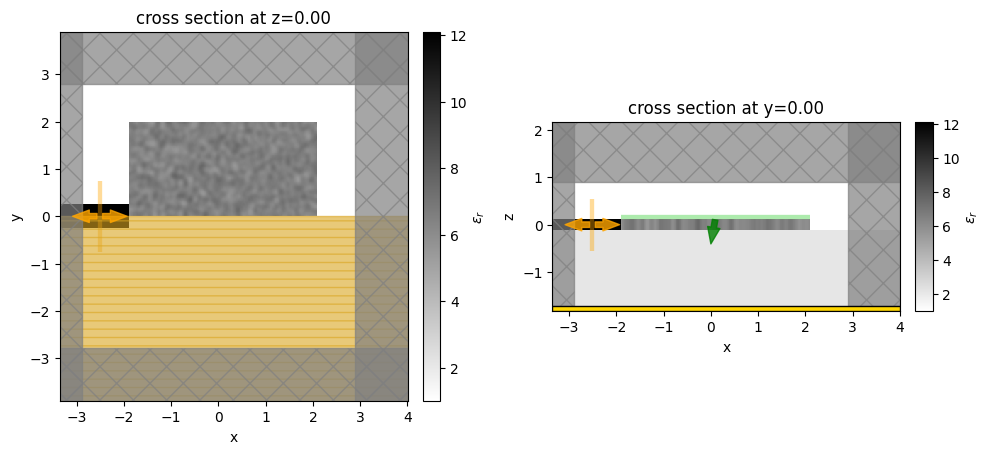

In [38]:
init_design = make_adjoint_sim(init_par, beta=init_beta)

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 10))
init_design.plot_eps(z=0, ax=ax1)
init_design.plot_eps(y=0, ax=ax2)
plt.show()


## Optimization

We need to provide an objective function and its gradients with respect to the design parameters of the optimization algorithm.

Our figure-of-merit (FOM) is the coupling efficiency of the incident power into the fundamental transverse electric mode of the $Si$ waveguide. The optimization algorithm will call the objective function at each iteration step. Therefore, the objective function will create the adjoint simulation, run it, and return the FOM value.

In [39]:
# Figure of Merit (FOM) calculation.
def fom(sim_data: JaxSimulationData) -> float:
    """Return the power at the mode index of interest."""
    output_amps = sim_data.output_data[0].amps
    amp = output_amps.sel(direction="-", f=freq, mode_index=0)
    return jnp.sum(jnp.abs(amp) ** 2)


# Objective function to be passed to the optimization algorithm.
def obj(
    design_param, beta: float = 1.0, step_num: int = None, verbose: bool = False
) -> float:
    sim = make_adjoint_sim(design_param, beta)
    task_name = "inv_des"
    if step_num:
        task_name += f"_step_{step_num}"
    sim_data = run(sim, task_name=task_name, verbose=verbose)
    fom_val = fom(sim_data)
    return fom_val


# Function to calculate the objective function value and its
# gradient with respect to the design parameters.
obj_grad = value_and_grad(obj)


Now, we are ready to run the optimization!

In [40]:
# Sets the loggin level to ERROR to reduce the amount of output.
td.config.logging_level = "ERROR"


# Definition of the optimization function.
def optimize(
    design_par,
    opt_steps=opt_steps,
    it_per_step=it_per_step,
    d_max=1.0,
    d_min=0.0,
    step_size=0.02,
    beta=1.0,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
):
    mt = np.zeros_like(design_par)
    vt = np.zeros_like(design_par)

    for step in range(opt_steps):
        for it in range(it_per_step):
            t = step * it_per_step + it + 1
            print(f"Step = {t}; Beta = {beta}")

            power, gradient = obj_grad(design_par, beta=beta, step_num=t)
            gradient = np.array(gradient).copy()

            mt = beta1 * mt + (1 - beta1) * gradient
            vt = beta2 * vt + (1 - beta2) * gradient**2
            mt_hat = mt / (1 - beta1**t)
            vt_hat = vt / (1 - beta2**t)

            update = step_size * (mt_hat / np.sqrt(vt_hat) + epsilon)

            obj_vals.append(power)
            print(f"\tObj = {power:.4e}")
            print(f"\tGrad. norm = {np.linalg.norm(gradient):.4e}")

            design_par += update
            design_par[design_par > d_max] = d_max
            design_par[design_par < d_min] = d_min

        beta = beta + del_beta

    return design_par, beta


# Run a new optimization or load the previous results.
if view_mode:
    final_par = init_par
    final_beta = init_beta
    obj_vals = prev_data["obj_vals"]
else:
    obj_vals = []
    final_par, final_beta = optimize(init_par)
    obj_val = obj(final_par, beta=final_beta)
    obj_vals.append(obj_val)

    # Saves the optimization data into a json file.
    data = [
        {
            "design_parameters": final_par.tolist(),
            "final_beta": final_beta,
            "obj_vals": np.array(obj_vals).tolist(),
        }
    ]
    json_string = json.dumps(data)
    with open(output_file, "w", encoding="utf-8") as file_json:
        file_json.write(json_string)


Step = 1; Beta = 1.0
	Obj = 1.3041e-03
	Grad. norm = 1.6596e-03
Step = 2; Beta = 1.0
	Obj = 2.0517e-02
	Grad. norm = 4.3521e-03
Step = 3; Beta = 1.0
	Obj = 5.4793e-02
	Grad. norm = 5.8280e-03
Step = 4; Beta = 1.0
	Obj = 1.0552e-01
	Grad. norm = 9.3773e-03
Step = 5; Beta = 1.0
	Obj = 1.7188e-01
	Grad. norm = 1.3299e-02
Step = 6; Beta = 2.0
	Obj = 3.2900e-01
	Grad. norm = 2.1515e-02
Step = 7; Beta = 2.0
	Obj = 4.2786e-01
	Grad. norm = 1.5476e-02
Step = 8; Beta = 2.0
	Obj = 5.1355e-01
	Grad. norm = 1.4670e-02
Step = 9; Beta = 2.0
	Obj = 5.8223e-01
	Grad. norm = 1.5316e-02
Step = 10; Beta = 2.0
	Obj = 6.3838e-01
	Grad. norm = 1.2665e-02
Step = 11; Beta = 3.0
	Obj = 6.7816e-01
	Grad. norm = 1.3468e-02
Step = 12; Beta = 3.0
	Obj = 7.2210e-01
	Grad. norm = 9.0771e-03
Step = 13; Beta = 3.0
	Obj = 7.5332e-01
	Grad. norm = 5.9530e-03
Step = 14; Beta = 3.0
	Obj = 7.6809e-01
	Grad. norm = 6.3704e-03
Step = 15; Beta = 3.0
	Obj = 7.8046e-01
	Grad. norm = 6.8555e-03
Step = 16; Beta = 4.0
	Obj = 7.763

### Optimization results.

After 150 iterations, a remarkable coupling efficiency value of 0.97 (-0.15 dB) was achieved at the central wavelength.

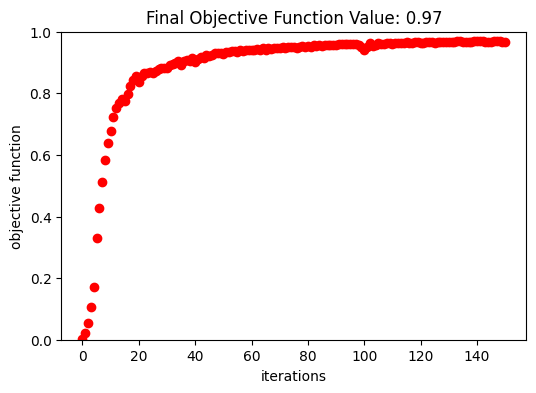

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(obj_vals, "ro")
ax.set_xlabel("iterations")
ax.set_ylabel("objective function")
ax.set_ylim(0, 1)
ax.set_title(f"Final Objective Function Value: {obj_vals[-1]:.2f}")
plt.show()


The final grating coupler structure is well binarized, with mostly black (`eps_max`) and white (`eps_min`) regions. To eliminate the small grayscale regions near the waveguide, the user should increase the value of `beta` further.

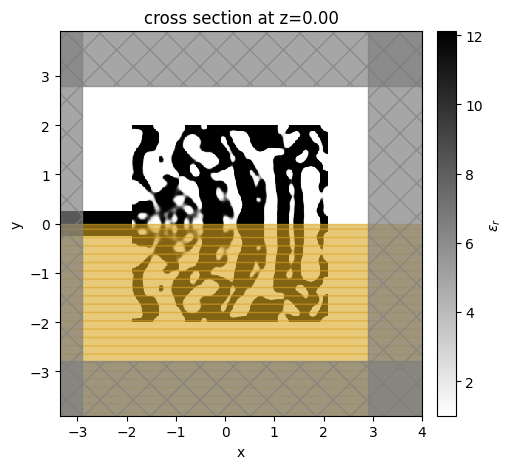

In [42]:
sim_final = make_adjoint_sim(final_par, beta=final_beta, unfold=True)
sim_final = sim_final.to_simulation()[0]
sim_final.plot_eps(z=0, source_alpha=0, monitor_alpha=0)
plt.show()


Once the inverse design is complete, we can visualize the field distributions and the wavelength dependent coupling efficiency.

In [43]:
# Field monitors to visualize the final fields.
field_xy = td.FieldMonitor(
    size=(td.inf, td.inf, 0),
    freqs=[freq],
    name="field_xy",
)

field_xz = td.FieldMonitor(
    size=(td.inf, 0, td.inf),
    freqs=[freq],
    name="field_xz",
)

# Monitor to compute the grating coulpler efficiency.
gc_efficiency = td.ModeMonitor(
    center=[mon_pos_x, 0, 0],
    size=[0, mon_w, mon_h],
    freqs=freqs,
    mode_spec=mode_spec,
    name="gc_efficiency",
)

sim_final = sim_final.copy(update=dict(monitors=(field_xy, field_xz, gc_efficiency)))
sim_data_final = web.run(sim_final, task_name="inv_des_final")


[04:48:06] Created task 'inv_des_final' with task_id 'fdve-6bbe1b35-c00a-46b6-bd80-da6fee8d3bdfv1'.   ]8;id=62664;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=255652;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py#186\186]8;;\

           View task using web UI at                                                                  ]8;id=19211;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=350251;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py#188\188]8;;\
           ]8;id=102708;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bbe1b35-c00a-46b6-bd80-da6fee8d3bdfv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=920830;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bbe1b35-c00a-46b6-bd80-da6fee8d3bdfv1\taskId]8;;\]8;id=102708;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bbe1b35-c00a-46b6-bd80-da6fee8d3bdfv1\=]8;;\]8;id=866561;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bbe1b35-c00a-46b6-bd80-da6fee8d3bdfv1\fdve]8;;\]8;id=102708;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bbe1b35-c00a-46b6-bd80-da6fee8d3bdfv1\-6bbe1b35-c00a-46b6-bd80-da6fee8d3bd]8;;\              
           ]8;id=102708;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6bbe1b35-c00a-46b6-bd80-da6fee8d3bdfv1\fv1']8;;\.                                                                                                   

Output()

Output()

[04:48:13] status = queued                                                                            ]8;id=616520;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=864683;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py#321\321]8;;\

Output()

[04:48:22] status = preprocess                                                                        ]8;id=278782;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=573599;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py#315\315]8;;\

[04:48:26] Maximum FlexCredit cost: 0.201. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=923649;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=262252;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py#338\338]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=780534;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=299384;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py#342\342]8;;\

[04:48:27] running solver                                                                             ]8;id=661821;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=582768;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py#352\352]8;;\

Output()

[04:49:01] early shutoff detected, exiting.                                                           ]8;id=778813;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=243355;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py#366\366]8;;\

           status = postprocess                                                                       ]8;id=829695;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=418123;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py#383\383]8;;\

Output()

[04:49:10] status = success                                                                           ]8;id=382601;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=103678;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py#390\390]8;;\

Output()

[04:49:14] loading SimulationData from simulation_data.hdf5                                           ]8;id=551943;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=188806;file:///home/emerson/miniconda3/envs/tidy3d_2.2.1/lib/python3.11/site-packages/tidy3d/web/webapi.py#568\568]8;;\

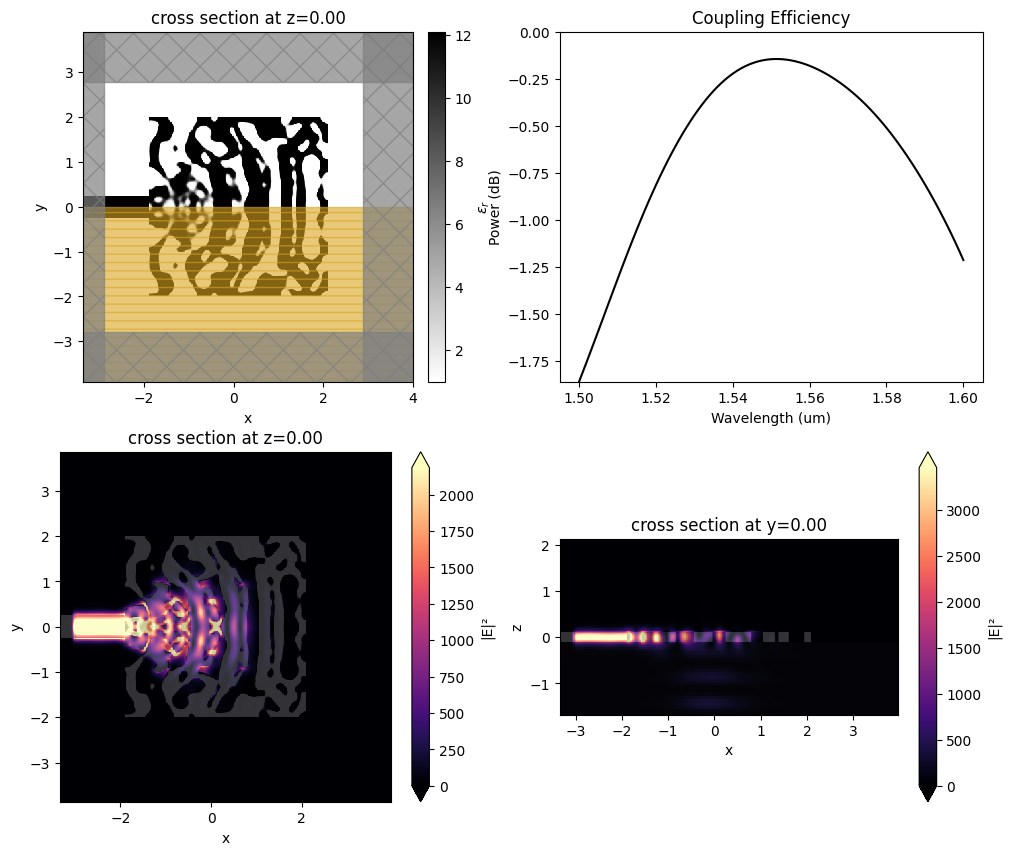

In [44]:
mode_amps = sim_data_final["gc_efficiency"]
coeffs_f = mode_amps.amps.sel(direction="-")
power_0 = np.abs(coeffs_f.sel(mode_index=0)) ** 2
power_0_db = 10 * np.log10(power_0)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
ax1 = sim_final.plot_eps(z=0, source_alpha=0, monitor_alpha=0, ax=ax1)
ax2.plot(wl_range, power_0_db, "-k")
ax2.set_xlabel("Wavelength (um)")
ax2.set_ylabel("Power (dB)")
ax2.set_ylim(np.amin(power_0_db), 0)
ax2.set_title("Coupling Efficiency")
ax3 = sim_data_final.plot_field("field_xy", "E", "abs^2", z=0, ax=ax3)
ax4 = sim_data_final.plot_field("field_xz", "E", "abs^2", y=0, ax=ax4)
